# Computer Vision Project - Classification of Flowers


In this project your objective is to create a model in order to classify flowers. Thiszip file contains all relevant data. 

1. The data contains two folders: *train* and *test*. The *train* folder consists of 5486-images to use for training while the *test* folder contains 1351-images you can use to test your model in a **train-test-split** validation style. We have omitted another set of 1352 validation images which we will use to benchmark your final models in the last lecture. 


2. We have provided you with two label files: *train_labels.csv* and *test_labels.csv*. Each file contains the filename of the corresponding image and the class label. In total we have **102 different classes** of flowers.  You can import the label files using the `import_labels()` function provided to you in this notebook.


3. Due to the large number of images, there is a good chance that you can not easily fit the entire training and testing data into RAM. We therefore give you an implementation of a `DataGenerator` class that can be used with keras. This class will read in the images from your hard-drive for each batch during during or testing. The class comes with some nice features that could improve your training significantly such as **image resizing**, **data augmentation** and **preprocessing**. Have a look at the code to find out how.

    Initialize data generators using labels and image source directory.

    `
    datagen_train = DataGenerator('train', y_train, batch_size, input_shape, ...)
    datagen_test = DataGenerator('test', y_test, batch_size, input_shape, ...)`

    Train your model using data generators.

    `model.fit(datagen_train, validation_data=datagen_test, ...)`
    
    
4. Select a suitable model for classification. It is up to you to decide all model parameters, such as **number of layers**, **number and size of filter** in each layer, using **pooling** or, **image-size**, **data-augmentation**, **learning rate**, ... 


5. **Document** your progress and your intermediate results (your failures and improvements). Describe why you selected certain model and training parameters, what worked, what did not work. Store the training history (loss and accuracy) and create corresponding plots. This documentation will be part of your final presentation and will be **graded**.


6. Feel free to explore the internet for suitable CNN models and re-use these ideas. If you use certain features we have not touched during the lecture such as Dropout, Residual Learning or Batch Normalization. Prepare a slide in your final presentation to explain in your own (basic) terms what these things to so we can all learn from your experience. **Notice:** Very large models might perform better but will be harder and slower to train. **Do not use a pre-trained model you find online!**


7. Prepare a notebook with your model such that we can use it in the final competition. This means, store your trained model using `model.save(...)`. Your saved models can be loaded via `tf.keras.models.load_model(...)`. We will then provide you with a new folder containing images (*validation*) and a file containing labels (*validation_labels.csv*) which have the same structure. Prepare a data generator for this validation data (test it using the test data) and supply it to the 
 `evaluate_model(model, datagen)` function provided to you.
 
 Your prepared notebook could look like this:
 
    `... import stuff 
    ... code to load the stored model ...
    y_validation = import_labels('validation_labels.csv')
    datagen_validation = DataGenerator('validation', y_validation, batch_size, input_shape)
    evaluate_model(model, datagen_validation)`


8. Prepare a 15-Minute presentation of your findings and final model presentation. A rough guideline what could be interesting to your audience:
    * Explain your models architecture (number of layers, number of total parameters, how long took it to train, ...)
    * Compare the training history of your experimentats visually
    * Explain your best model (why is it better)
    * Why did you take certain decision (parameters, image size, batch size, ...)
    * What worked, what did not work (any ideas why?)
    * **What did you learn?**

In [6]:
# Read in label file and return a dictionary {'filename' : label}.
#
def import_labels(label_file):
    labels = dict()

    import csv
    with open(label_file) as fd:
        csvreader = csv.DictReader(fd)

        for row in csvreader:
            labels[row['filename']] = int(row['label'])
    return labels

In [7]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class DataGenerator(keras.utils.Sequence):

    def __init__(self, img_root_dir, labels_dict, batch_size, target_dim, preprocess_func=None, use_augmentation=False):
        self._labels_dict = labels_dict
        self._img_root_dir = img_root_dir
        self._batch_size = batch_size
        self._target_dim = target_dim
        self._preprocess_func = preprocess_func
        self._n_classes = len(set(self._labels_dict.values()))
        self._fnames_all = list(self._labels_dict.keys())
        self._use_augmentation = use_augmentation

        if self._use_augmentation:
            self._augmentor = ImageDataGenerator(
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self._fnames_all)) / self._batch_size)

    def on_epoch_end(self):
        self._indices = np.arange(len(self._fnames_all))
        np.random.shuffle(self._indices)

    def __getitem__(self, index):
        indices = self._indices[index * self._batch_size:(index+1)*self._batch_size]

        fnames = [self._fnames_all[k] for k in indices]
        X,Y = self.__load_files__(fnames)

        return X,Y

    def __load_files__(self, batch_filenames):
        X = np.empty((self._batch_size, *self._target_dim, 3))
        Y = np.empty((self._batch_size), dtype=int)

        for idx, fname in enumerate(batch_filenames):
            img_path = os.path.join(self._img_root_dir, fname)
            img = image.load_img(img_path, target_size=self._target_dim)
            x = image.img_to_array(img)
           
            if self._preprocess_func is not None:
                x = self._preprocess_func(x)

            X[idx,:] = x 
            Y[idx] = self._labels_dict[fname]-1

        if self._use_augmentation:
            it = self._augmentor.flow(X, batch_size=self._batch_size, shuffle=False)
            X = it.next()

        if self._preprocess_func is not None:
            X = self._preprocess_func(X/255.0)

        return X, tf.keras.utils.to_categorical(Y, num_classes=self._n_classes)

In [8]:
# Get the Labels
y_train = import_labels(r'labels\train_labels.csv')
y_test = import_labels(r'labels\test_labels.csv')

In [9]:
# Define properties for DataGenerator
batch_size = 13
input_shape = (200,200)

def preprocess(x):
    return x

In [10]:
# Get training and testing Data
datagen_train = DataGenerator('train_data', y_train, batch_size, input_shape, preprocess_func=preprocess, use_augmentation=True)
datagen_test = DataGenerator('test_data', y_test, batch_size, input_shape, preprocess_func=preprocess)

In [11]:
# Figure out number of classes
new_val = y_train.values()
fin_max = max(new_val)
print(fin_max)

102


In [12]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Input, Dropout, BatchNormalization, GlobalAveragePooling2D

model = keras.Sequential()

# Note, we habe to tell keras the corret input shape which ist the dimension of our images
model.add(Input(shape=(200,200,3)))

# Add a convolution layer with 16 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

# Add a convolution layer with 16 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

# Add a convolution layer with 32 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

# Add a convolution layer with 32 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters =128, kernel_size = (3,3), padding='same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

# Add a convolution layer with 64 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding='same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

# Add a convolution layer with 64 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding='same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
#model.add(Dropout(0.5))

# Add a convolution layer with 64 filters, filters of size 3x3 and relu as activation
model.add(Conv2D(filters = 512, kernel_size = (3,3), padding='same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
#model.add(Dropout(0.5))

# Convert to a fully-connected network
model.add(GlobalAveragePooling2D())

# Add classifier part
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))

# The mumber of output neurons must be equal to the number of classes
model.add(Dense(102, activation='softmax'))

In [13]:
# Defining the Optimizer
from tensorflow.keras.optimizers import Nadam
opt = Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                        

In [14]:
# Training the Model
epochs = 200
history = model.fit(datagen_train, validation_data=datagen_test, epochs=epochs)

Epoch 1/200
422/422 [==============================] - 670s 2s/step - loss: 3.8107 - accuracy: 0.1497 - val_loss: 3.9556 - val_accuracy: 0.1337
Epoch 2/200
422/422 [==============================] - 654s 2s/step - loss: 2.9131 - accuracy: 0.2754 - val_loss: 3.6088 - val_accuracy: 0.2957
Epoch 3/200
422/422 [==============================] - 522s 1s/step - loss: 2.4219 - accuracy: 0.3740 - val_loss: 2.3854 - val_accuracy: 0.4190
Epoch 4/200
422/422 [==============================] - 495s 1s/step - loss: 2.0883 - accuracy: 0.4355 - val_loss: 2.3352 - val_accuracy: 0.4347
Epoch 5/200
422/422 [==============================] - 496s 1s/step - loss: 1.8285 - accuracy: 0.4984 - val_loss: 2.0382 - val_accuracy: 0.5026
Epoch 6/200
422/422 [==============================] - 499s 1s/step - loss: 1.6230 - accuracy: 0.5594 - val_loss: 1.9356 - val_accuracy: 0.5093
Epoch 7/200
422/422 [==============================] - 492s 1s/step - loss: 1.4389 - accuracy: 0.5935 - val_loss: 1.4074 - val_accuracy:

422/422 [==============================] - 488s 1s/step - loss: 0.1945 - accuracy: 0.9384 - val_loss: 0.7124 - val_accuracy: 0.8439
Epoch 58/200
422/422 [==============================] - 488s 1s/step - loss: 0.1800 - accuracy: 0.9440 - val_loss: 0.6174 - val_accuracy: 0.8588
Epoch 59/200
422/422 [==============================] - 487s 1s/step - loss: 0.1690 - accuracy: 0.9451 - val_loss: 0.6030 - val_accuracy: 0.8648
Epoch 60/200
422/422 [==============================] - 485s 1s/step - loss: 0.1574 - accuracy: 0.9482 - val_loss: 0.7431 - val_accuracy: 0.8364
Epoch 61/200
422/422 [==============================] - 482s 1s/step - loss: 0.1590 - accuracy: 0.9488 - val_loss: 0.7470 - val_accuracy: 0.8439
Epoch 62/200
422/422 [==============================] - 377s 892ms/step - loss: 0.1651 - accuracy: 0.9471 - val_loss: 0.7107 - val_accuracy: 0.8469
Epoch 63/200
422/422 [==============================] - 456s 1s/step - loss: 0.1542 - accuracy: 0.9548 - val_loss: 0.6112 - val_accuracy: 0.

422/422 [==============================] - 490s 1s/step - loss: 0.0787 - accuracy: 0.9747 - val_loss: 0.6476 - val_accuracy: 0.8887
Epoch 114/200
422/422 [==============================] - 490s 1s/step - loss: 0.0829 - accuracy: 0.9723 - val_loss: 0.5656 - val_accuracy: 0.8917
Epoch 115/200
422/422 [==============================] - 490s 1s/step - loss: 0.1147 - accuracy: 0.9648 - val_loss: 0.5845 - val_accuracy: 0.8857
Epoch 116/200
422/422 [==============================] - 488s 1s/step - loss: 0.1109 - accuracy: 0.9676 - val_loss: 0.7740 - val_accuracy: 0.8596
Epoch 117/200
422/422 [==============================] - 488s 1s/step - loss: 0.0731 - accuracy: 0.9776 - val_loss: 0.6907 - val_accuracy: 0.8663
Epoch 118/200
422/422 [==============================] - 485s 1s/step - loss: 0.0762 - accuracy: 0.9774 - val_loss: 0.6835 - val_accuracy: 0.8783
Epoch 119/200
422/422 [==============================] - 487s 1s/step - loss: 0.0770 - accuracy: 0.9748 - val_loss: 0.6216 - val_accuracy:

422/422 [==============================] - 485s 1s/step - loss: 0.0569 - accuracy: 0.9810 - val_loss: 0.5867 - val_accuracy: 0.8954
Epoch 170/200
422/422 [==============================] - 489s 1s/step - loss: 0.0715 - accuracy: 0.9774 - val_loss: 0.5907 - val_accuracy: 0.8910
Epoch 171/200
422/422 [==============================] - 487s 1s/step - loss: 0.0676 - accuracy: 0.9781 - val_loss: 0.5483 - val_accuracy: 0.8962
Epoch 172/200
422/422 [==============================] - 488s 1s/step - loss: 0.0592 - accuracy: 0.9803 - val_loss: 0.5376 - val_accuracy: 0.9081
Epoch 173/200
422/422 [==============================] - 488s 1s/step - loss: 0.0699 - accuracy: 0.9781 - val_loss: 0.6845 - val_accuracy: 0.8827
Epoch 174/200
422/422 [==============================] - 487s 1s/step - loss: 0.0538 - accuracy: 0.9814 - val_loss: 0.5472 - val_accuracy: 0.9014
Epoch 175/200
422/422 [==============================] - 487s 1s/step - loss: 0.0632 - accuracy: 0.9830 - val_loss: 0.6099 - val_accuracy:

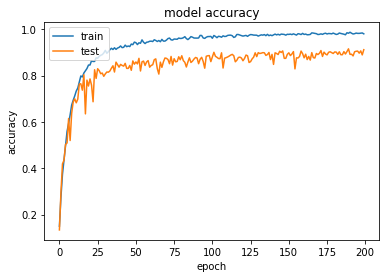

In [15]:
# Showing the accuracy of the training
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

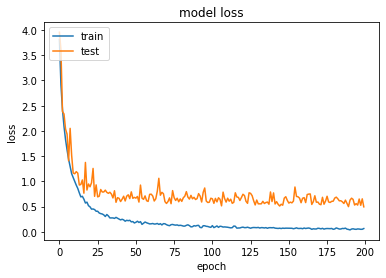

In [16]:
# Showing the loss of the training
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model losvs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

103/103 [==============================] - 25s 234ms/step


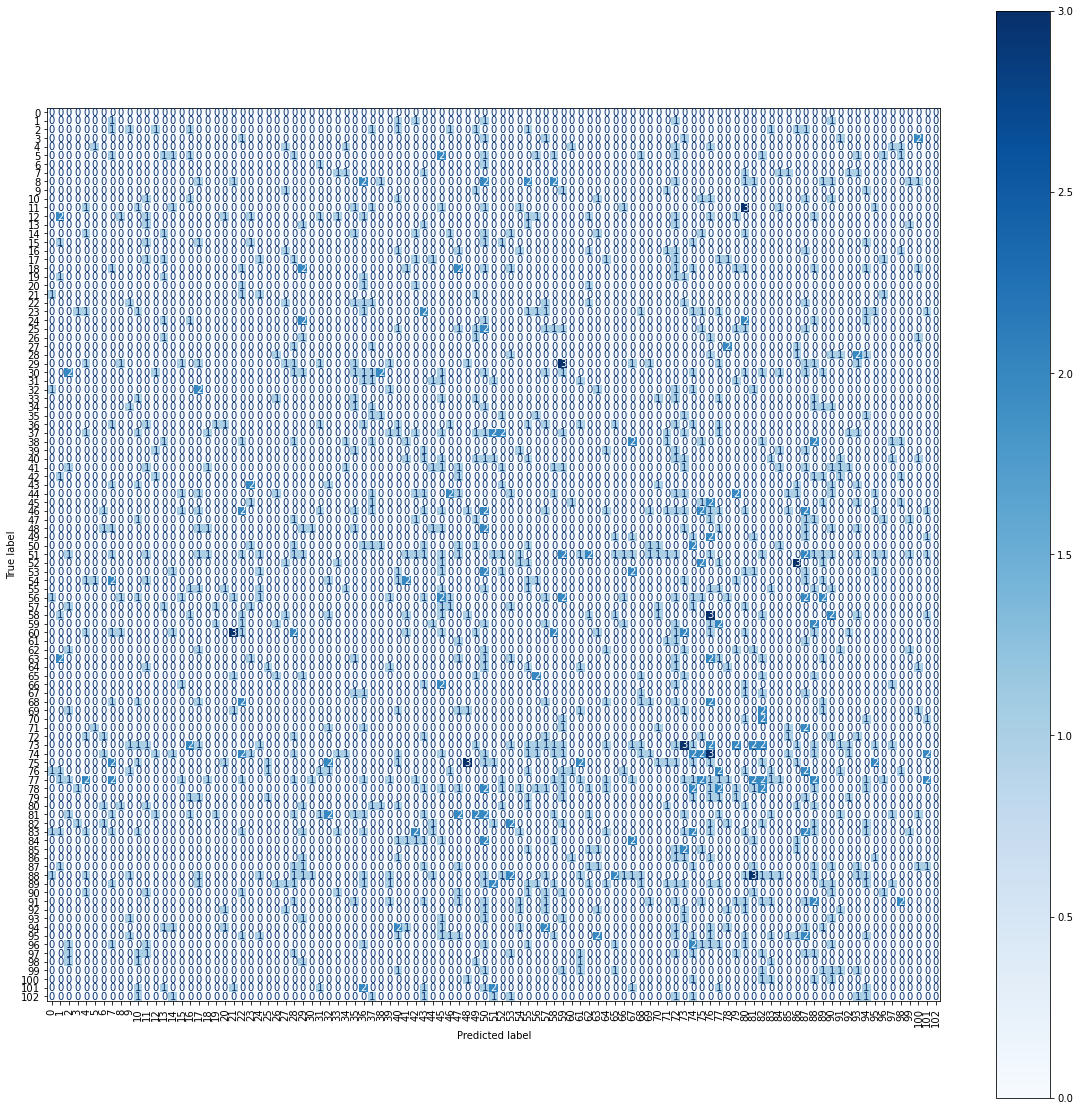

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Confution Matrix
Y_pred = model.predict(datagen_test)
y_pred = np.argmax(Y_pred, axis=1)
y_test_val = np.fromiter(y_test.values(), dtype=int)
y_test_cut = np.zeros(len(y_pred))
for idx in range(len(y_pred)):
    y_test_cut[idx] = y_test_val[idx]

cm = confusion_matrix(y_test_cut, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [18]:
# Save Model
model.save('bestResultV03.h5')

INFO:tensorflow:Assets written to: finalResult012\assets


INFO:tensorflow:Assets written to: finalResult012\assets
